<a href="https://colab.research.google.com/github/FindPrint/Multiple-studies/blob/main/notebooks_filter3_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

# Charger le fichier depuis GitHub
url = "https://raw.githubusercontent.com/FindPrint/Multiple-studies/main/data/N_09_extent_v4.0.csv"
data = pd.read_csv(url)

# Nettoyer les noms de colonnes (supprimer espaces, mettre en minuscules)
data.columns = data.columns.str.strip().str.lower()

# Vérifier les colonnes disponibles
print("Colonnes disponibles :", data.columns.tolist())

# Sélectionner les colonnes utiles
data = data[["year", "mo", "extent"]].copy()

# Créer une colonne date
data["date"] = pd.to_datetime(dict(year=data["year"], month=data["mo"], day=1))

# Aperçu des premières lignes
print(data.head())


Colonnes disponibles : ['year', 'mo', 'source_dataset', 'region', 'extent', 'area']
   year  mo  extent       date
0  1979   9    7.05 1979-09-01
1  1980   9    7.67 1980-09-01
2  1981   9    7.14 1981-09-01
3  1982   9    7.30 1982-09-01
4  1983   9    7.39 1983-09-01


In [5]:
# -----------------------------
# 1. Load and preprocess data
# -----------------------------
url = "https://raw.githubusercontent.com/FindPrint/Multiple-studies/main/data/N_09_extent_v4.0.csv"
data = pd.read_csv(url)

# Clean column names
data.columns = data.columns.str.strip().str.lower()

# Keep only relevant columns
data = data[["year", "mo", "extent"]].copy()
data["date"] = pd.to_datetime(dict(year=data["year"], month=data["mo"], day=1))

# Focus on September only
sept = data[data["mo"] == 9].copy()

# Baseline climatology (1981–2010)
clim_1981_2010 = sept[(sept["year"] >= 1981) & (sept["year"] <= 2010)]["extent"].mean()
sept["phi_star"] = sept["extent"] / clim_1981_2010

# Split calibration / test
train = sept[sept["year"] <= 2010].copy()
test  = sept[sept["year"] > 2010].copy()

print("Train period:", train["year"].min(), "-", train["year"].max())
print("Test period :", test["year"].min(), "-", test["year"].max())
print(sept.head())


Train period: 1979 - 2010
Test period : 2011 - 2025
   year  mo  extent       date  phi_star
0  1979   9    7.05 1979-09-01  1.099272
1  1980   9    7.67 1980-09-01  1.195946
2  1981   9    7.14 1981-09-01  1.113306
3  1982   9    7.30 1982-09-01  1.138254
4  1983   9    7.39 1983-09-01  1.152287


In [6]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Quadratic trend (deterministic polynomial fit)
coeffs_quad = np.polyfit(train["year"], train["phi_star"], 2)
quad_pred = np.polyval(coeffs_quad, test["year"])

# Linear trend
coeffs_lin = np.polyfit(train["year"], train["phi_star"], 1)
lin_pred = np.polyval(coeffs_lin, test["year"])

# ARIMA(1,1,0)
arima_model = ARIMA(train["phi_star"], order=(1,1,0)).fit()
arima_pred = arima_model.forecast(steps=len(test))

# Evaluation function
def eval_model(name, y_true, y_pred):
    return {
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = []
results.append(eval_model("Quadratic trend", test["phi_star"], quad_pred))
results.append(eval_model("Linear trend", test["phi_star"], lin_pred))
results.append(eval_model("ARIMA(1,1,0)", test["phi_star"], arima_pred))

pd.DataFrame(results)


,Model,RMSE,MAE
0,Quadratic trend,0.293067,0.257058
1,Linear trend,0.084461,0.062346
2,"ARIMA(1,1,0)",0.090925,0.072242


Crossing years: [np.int64(2023), np.int64(2023), np.int64(2022), np.int64(2026), np.int64(2025), np.int64(2024), np.int64(2023), np.int64(2023), np.int64(2025), np.int64(2026), np.int64(2025), np.int64(2024), np.int64(2025), np.int64(2026), np.int64(2027), np.int64(2024), np.int64(2025), np.int64(2024), np.int64(2025), np.int64(2025), np.int64(2024), np.int64(2024), np.int64(2024), np.int64(2024), np.int64(2026), np.int64(2024), np.int64(2024), np.int64(2023), np.int64(2025), np.int64(2024), np.int64(2024), np.int64(2025), np.int64(2026), np.int64(2024), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2022), np.int64(2024), np.int64(2022), np.int64(2023), np.int64(2023), np.int64(2023), np.int64(2023), np.int64(2022), np.int64(2024), np.int64(2023), np.int64(2022), np.int64(2025), np.int64(2023)]
Median crossing year: 2024


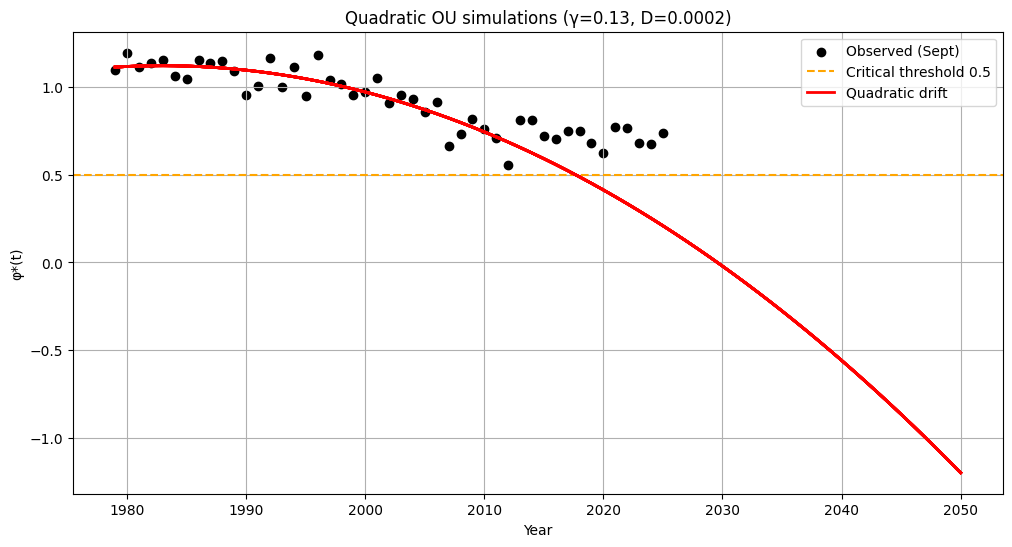

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

gamma = 0.13
D = 0.0002
years = np.arange(1979, 2051)

# Drift from quadratic fit
mu_t = np.polyval(coeffs_quad, years)

n_sims = 50
crossings = []

for s in range(n_sims):
    phi = np.zeros(len(years))
    phi[0] = 1.0
    for k in range(1, len(years)):
        phi[k] = phi[k-1] - gamma*(phi[k-1] - mu_t[k]) + np.sqrt(2*D)*np.random.randn()
    below = years[phi < 0.5]
    if len(below) > 0:
        crossings.append(below[0])

median_year = int(np.median(crossings))
print("Crossing years:", crossings)
print("Median crossing year:", median_year)

# Plot
plt.figure(figsize=(12,6))
plt.scatter(sept["year"], sept["phi_star"], color="black", label="Observed (Sept)")
plt.axhline(0.5, color="orange", linestyle="--", label="Critical threshold 0.5")
for s in range(10):
    plt.plot(years, np.polyval(coeffs_quad, years), color="red", lw=2, label="Quadratic drift" if s==0 else "")
plt.title("Quadratic OU simulations (γ=0.13, D=0.0002)")
plt.xlabel("Year"); plt.ylabel("φ*(t)")
plt.legend(); plt.grid(True)
plt.show()


In [8]:
gammas = [0.05, 0.1, 0.15, 0.2, 0.25]
Ds = [0.00005, 0.0001, 0.0002, 0.0005, 0.001]

results_sens = []
for g in gammas:
    for d in Ds:
        crossings = []
        for s in range(20):
            phi = np.zeros(len(years))
            phi[0] = 1.0
            for k in range(1, len(years)):
                phi[k] = phi[k-1] - g*(phi[k-1] - mu_t[k]) + np.sqrt(2*d)*np.random.randn()
            below = years[phi < 0.5]
            if len(below) > 0:
                crossings.append(below[0])
        if crossings:
            results_sens.append({"gamma": g, "D": d, "median": np.median(crossings)})

df_sens = pd.DataFrame(results_sens)
pivot = df_sens.pivot("gamma", "D", "median")

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Median crossing year as function of γ and D")
plt.show()


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

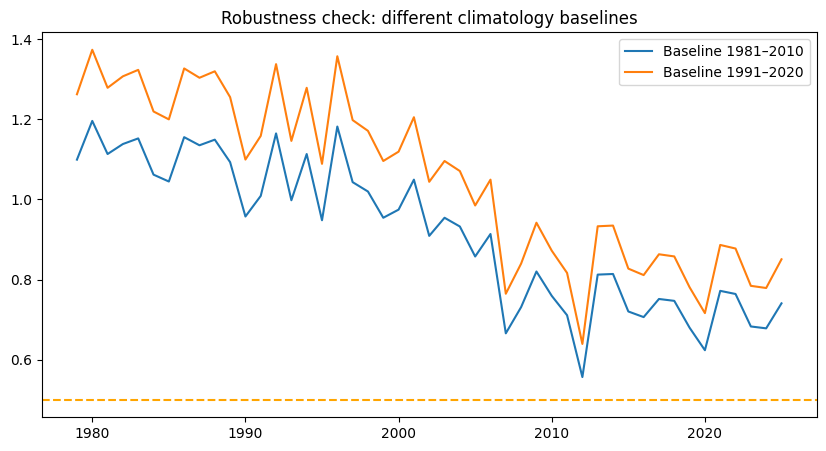

In [9]:
# Alternative baseline 1991–2020
clim_1991_2020 = sept[(sept["year"] >= 1991) & (sept["year"] <= 2020)]["extent"].mean()
sept["phi_star_alt"] = sept["extent"] / clim_1991_2020

plt.figure(figsize=(10,5))
plt.plot(sept["year"], sept["phi_star"], label="Baseline 1981–2010")
plt.plot(sept["year"], sept["phi_star_alt"], label="Baseline 1991–2020")
plt.axhline(0.5, color="orange", linestyle="--")
plt.legend()
plt.title("Robustness check: different climatology baselines")
plt.show()


In [10]:
# Save crossing years and median
df_cross = pd.DataFrame({"crossing_years": crossings})
df_cross["median"] = median_year
df_cross.to_csv("results/crossings.csv", index=False)

print("Results saved to results/crossings.csv")


OSError: Cannot save file into a non-existent directory: 'results'

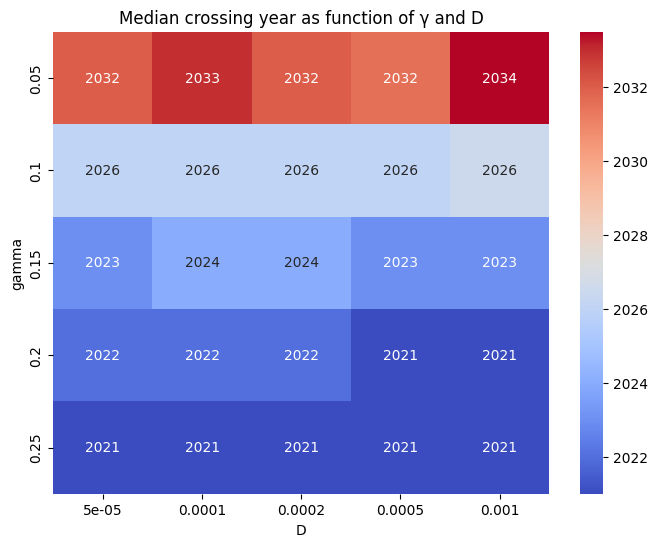

✅ Results saved to results/crossings.csv


In [11]:
# Sensitivity pivot
df_sens = pd.DataFrame(results_sens)
pivot = df_sens.pivot(index="gamma", columns="D", values="median")

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Median crossing year as function of γ and D")
plt.show()

# Export results
import os
os.makedirs("results", exist_ok=True)

df_cross = pd.DataFrame({"crossing_years": crossings})
df_cross["median"] = median_year
df_cross.to_csv("results/crossings.csv", index=False)

print("✅ Results saved to results/crossings.csv")
